In [72]:
# Load packages
import pandas as pd
from sklearn import datasets, linear_model, utils, preprocessing
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import statsmodels.api as sm
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datetime import date
from scipy.signal import savgol_filter
from scipy import stats
import re
import time
import datetime
from pylab import *
import matplotlib.pyplot as plt
import seaborn as sns
import dill

In [73]:
# Set parameters
curryr = 2021
currqtr = 4
m = 12

prevyr = 2021
prevqtr = 3
prev_m = 9

sector = "Off"
est_yr = 2017
est_qtr = 4

forecast_end_yr = 2030

# Data File location
genmet_loc = '/home/central/master-data/genmet.dta'
subnames_loc = '/home/central/master-datasubname.dta'
submarkettrend_loc = '/home/central/vc/mfp/finaltoit/data' + str(prevyr) + 'q' + str(prevqtr) + '/data'+ str(prevyr) + 'm' + str(prev_m) + '/qa/submarkettrends.dta'
markettrend_loc = '/home/central/vc/mfp/finaltoit/data' + str(prevyr) + 'q' + str(prevqtr) + '/data'+ str(prevyr) + 'm' + str(prev_m) + '/qa/markettrends.dta'
offhet_test_loc = '/home/central/metcast/data/' + sector.lower() + '/download/current/offhet-' + str(est_yr) + 'q' + str(est_qtr) + '.log'
ECCAdata_loc = '/home/central/metcast/data/rfa/current/rfa_' + str(curryr) + 'q' + str(currqtr) + '_final.dta'
submarket_old_loc = '/home/central/vc/mfp/finaltoit/data' + str(est_yr) + 'q' + str(est_qtr) + '/data'+ str(est_yr) + 'm' + str(est_qtr*3) + '/qa/submarkettrends.dta'
offhet_loc = '/home/central/metcast/data/' + sector.lower() + '/download/current/offhet.log'
offsubtrnds_loc = '/home/central/subcast/data/' + sector.lower() + '/download/current/offsubtrnds.csv'
ECCA_gdp_loc = '/home/central/cb/ecca/data/output/2022_1/METRO_GDP_PROCESSED.csv'
ECCA_US_loc = '/home/central/cb/ecca/data/output/2022_1/NATIONAL_SET_PROCESSED.csv'
offmets_loc = '/home/central/master-do-files/keep_US_offmets.do'
df_rol_loc = '/home/central/subcast/data/' + sector.lower() + '/forecast/current/offsubtest_'+ str(prevyr) + 'q' + str(prevqtr) +'.dta'


# Load Data
genmet = pd.read_stata(genmet_loc)
offmets = open(offmets_loc, "r").read()
offmets_list = re.findall(r'"(.*?)"', offmets)

submarkettrend = pd.read_stata(submarkettrend_loc)
markettrend = pd.read_stata(markettrend_loc)
df_offhet_test = pd.read_table(offhet_test_loc, header=None, names = ['MSA', 'Sector', 'Geosub', 'Subname', 'Year', 'Qtr', 'Size', 'H_E'] )
df_offhet_test.loc[df_offhet_test.MSA.isna(), "MSA"] = "NA"
df_offhet_test = df_offhet_test.drop(0)
df_offhet_test.Geosub = df_offhet_test.Geosub.astype('int')
df_offhet_test.Year = df_offhet_test.Year.astype('int')
df_offhet_test.Qtr = df_offhet_test.Qtr.astype('int')
df_offhet_test.Size = df_offhet_test.Size.astype('int')
# df_apthet = pd.read_table(apthet_loc, header=None, names = ['MSA', 'Sector', 'Geosub', 'Subname', 'Year', 'Qtr', 'Size', 'H_E'] )
# df_apthet.loc[df_apthet.MSA.isna(), "MSA"] = "NA"
df_offhet = pd.read_table(offhet_loc, header =0)
df_offhet = df_offhet.dropna(axis=1, how='all')
df_offhet.columns = df_offhet.columns.str.replace(' ', '')
df_offhet.loc[df_offhet.MSA.isna(), "MSA"] = "NA"
df_offhet = df_offhet.drop(0)
df_offhet.Geosub = df_offhet.Geosub.astype('int')
df_offhet.Year = df_offhet.Year.astype('int')
df_offhet.Qtr = df_offhet.Qtr.astype('int')
df_offhet.Size = df_offhet.Size.astype('int')

df_offsubtrnds = pd.read_csv(offsubtrnds_loc)
df_offsubtrnds.loc[df_offsubtrnds.msa.isna(), 'msa'] = "NA"


df_gdp = pd.read_csv(ECCA_gdp_loc)
df_ecca_US = pd.read_csv(ECCA_US_loc)
df_gdp.loc[df_gdp.metcode.isna(), "metcode"] = "NA"
df_gdp_dc = df_gdp[df_gdp.metcode=="SV"]
df_gdp_dc.metcode = "DC"
df_gdp = pd.concat([df_gdp,  df_gdp_dc])


df_rfa = pd.read_stata(ECCAdata_loc)
submarket_old = pd.read_stata(submarket_old_loc)
df_rol = pd.read_stata(df_rol_loc)
df_rol = df_rol[["metcode", "subid", "yr", "qtr", "cons", "h","e", "Bcon", "abs", "Babs",
                 "vac", "Bvac", "mrent", "Bmrent" ,"G_mrent" ,"merent", "G_merent", "Bmerent", "gap", "Bgap"]]
df_rol = df_rol.rename(columns = { 'h' : 'rol_h', 'e' : 'rol_e', 'cons' : 'rolscon',
                                'Bcon' : 'rolcons', 'abs' : 'rolsabs', 'vac' : 'rolsvac',
                                'Babs' : 'Brolabs', 'mrent' : 'rolsmre', 'Bvac' : 'rolvac',
                                'Bmrent' : 'rolmrent', 'G_mrent' : 'grolsmre',
                                'merent' : 'rolmere', 'G_merent' : 'grolsmer', 
                                'Bmerent' : 'Brolmeren', 'gap' : 'rolsgap', 
                                'Bgap' : 'Brolgap'
                         })

In [74]:
yr_training = 2019
testing_yr_begin = 1989
re_estimate_model = True
permit_lag_yr = 1

try:
    del df_forecast
    del Coef_table_con
    del Coef_table_vac
    del Coef_table_rent
    del Coef_table_gap
    del df_error_con
    del df_error_vac
    del df_error_rent
    del df_error_gap
except:
    pass

metro_list = markettrend[(markettrend.sector==sector)][['metrocode']].drop_duplicates()
count_metro = markettrend[(markettrend.sector==sector)][['metrocode']].drop_duplicates().shape[0]
print("There are", count_metro, "metros in the" , sector, "sector.")

There are 214 metros in the Off sector.


In [79]:
# Estimate models for metros. 
# We forecasted the next ten years in previous version, and the code didn't cause any error.

for metro in offmets_list:
# Format data for modeling
    df = markettrend[(markettrend.metrocode==metro) & (markettrend.sector==sector)]
    df = df[(df.quarter!=5) & (df.totalmonths).isnull()].dropna(how='all', axis = 1)  # select quarterly data
    df['marketrentpctchange'] = df.marketrentpctchange/100
    df['effrentpchange'] = df.effrentpchange/100
    df['vacpercent'] = df.vacpercent/100
    df['vacpercentptchg'] = df.vacpercentptchg/100
    
    df_ecca = df_rfa.merge(df_gdp, on = ['metcode', 'yr', 'qtr'],how = 'left')
    df_ecca = df_ecca.merge(df_ecca_US, left_on = ['yr', 'qtr'], right_on = ['YR', 'QTR'],how = 'left')
    df = df.merge(df_ecca[(df_ecca.metcode==metro) & (df_rfa.qtr!=5)], left_on=['metrocode', 'year', 'quarter'], right_on=['metcode', 'yr', 'qtr'], how='right' )
#     df = df.merge(df_HE, left_on=['yr', 'qtr'], right_on=['Year', 'Qtr'], how = 'left')
#     df.loc[(df.H.isna()) & (df.yr < curryr+3), 'H'] = 0
#     df.loc[(df.H.isna()) & (df.yr >= curryr+3), 'H'] = df.completions.mean()
  
    yr_earlist = df[df.metrocode.notna()].year.min()
    df = df[(df.yr >= yr_earlist ) & (df.yr<= curryr + 10)]
    df = df[(df.yr > yr_earlist) | (df.qtr==4)]
    df['Month'] = df.qtr*3
    df['time'] = pd.to_datetime(df['yr'].astype(int).astype(str)  + df['Month'].astype(int).astype(str), format='%Y%m') 

    df= df.sort_values(['yr', 'qtr'])
    df = df[df.yr <= forecast_end_yr]
    # for i in ['metcode', 'state', 'cbsa', 'longmet', 'region', 'yr', 'qtr', 'VINTAGE']:
    #          del df[i] # preparing data table for analysis

    df_copy = df.copy()

    ## Transform all level data to percentage change
    df['inv_chg'] = df.inventory.pct_change(fill_method=None).shift()
    df['inv_lag'] = df['inventory'].shift()  
    df['completions_lag'] = df['completions'].shift()

### calculate z-scores
    cols = ['gdp',  'qfet', 'offemp', 'YIELD12M', 'CREPIOFF']
    for col in cols:
        col_zscore = col + '_zscore'
        df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    df = df.replace([np.inf, -np.inf], 0)

## Select Variables
    X_REIS = ['inv_lag','completions_lag']
    X_ECCA = ['gdp_zscore',  'qfet_zscore', 'YIELD12M_zscore', 'CREPIOFF_zscore']
    X_select = X_REIS + X_ECCA

# Create training set and testing set
    df_training = df[df.yr <= yr_training][X_select + ['completions']]
    df_training = df_training.dropna(axis=0, how='any')
    col_export = ['sector', 'subsector', 'metrocode', 'year', 'quarter']
    df_testing = df[(df.yr >= testing_yr_begin) & (df.yr <= 2019)][col_export + X_select + ['completions']]
    df_testing = df_testing.dropna(axis=0, how='any')
    y = df_training.completions
    X = df_training[X_select]


    ## Estimate Ridge Model
    tscv = TimeSeriesSplit(n_splits=4)
    clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
        alphas=np.logspace(-8, 0, 20))
    #         clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
    #             alphas=np.logspace(-8, 0, 20))
    X = df_training[X_select]
    X_list = X_select
    clf.fit(X,y)
    
    # Save the model
    try: 
        Coef_table_con
    except NameError: 
        Coef_table_con = pd.DataFrame (list(X.columns) + ["Intercept"],columns=['Variables'])
    Coef_table_con[metro] = list(clf.coef_) + [clf.intercept_]
    
    output = open('/home/central/KF_XL_SY/Model_off/metro_model/con_' + metro+ '.pkl', 'wb')
    dill.dump(clf, output)
    output.close()
    
    #try:
        #while df[df.yr >curryr-1].completions.isna().sum()>0:
            #df.loc[(df.completions.isna()) & (df.yr >2015) & (df.inv_lag.notna()), 'completions'] =clf.predict(df[(df.completions.isna()) & (df.yr >2015) & (df.inv_lag.notna())][X_list])
            #df.loc[df.completions < 10000, "completions"] = 0.
            #df.loc[(df.inventory.isna()) & (df.inv_lag.notna()), 'inventory'] = df[(df.inventory.isna()) & (df.inv_lag.notna())].inv_lag + df[(df.inventory.isna()) & (df.inv_lag.notna())].completions
            #df['inv_lag'] = df['inventory'].shift()   
            #df['inv_chg'] = df.inventory.pct_change(fill_method=None).shift()
            #df['completions_lag'] = df['completions'].shift()
    #except:
        #print(metro, "Something in the construction forecast went wrong")
    
    df_testing['y_hat'] = clf.predict(df_testing[X_list]) 
    df_testing['y_hat'] = np.where(df_testing['y_hat']<10000, 0, df_testing['y_hat'])
    
    try: 
        df_error_con
    except NameError: 
        df_error_con = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'year', 'quarter', 'y_hat', "completions"]
    df_error_con = pd.concat([df_error_con,  df_testing[col_export]])

# Estimate Vacancy Model (Hendershott 2009)
## Prepare data
    df['qfet_ln_diff'] = np.log(df['qfet']).diff()
    df['qfet_ln_diff_lag'] = np.log(df['qfet']).diff().shift()
    df['qfet_ln_diff_lag2'] = np.log(df['qfet']).diff().shift(2)
    df['USGDP_ln_diff'] = df['USGDP'].pct_change(periods=4)
    df['USGDP_ln_diff_lag'] = df['USGDP'].pct_change(periods=4).shift()
    df['gdp_ln_diff'] = df['gdp'].pct_change(periods=4)
    df['gdp_ln_diff_lag'] = df['gdp'].pct_change(periods=4).shift()
    df['inv_ln_diff'] = np.log(df['inventory']).diff()
    df['vac_lag'] = (df.vacpercent).shift()
    df['vacpercentptchg_lag'] = (df.vacpercentptchg).shift()

    ## Select Variables
    X_REIS = ['inv_ln_diff', 'vac_lag','vacpercentptchg_lag']
    X_ECCA = ['qfet_ln_diff', 'qfet_ln_diff_lag', 'qfet_ln_diff_lag2', 'USGDP_ln_diff', 'USGDP_ln_diff_lag']
    X_select = X_REIS + X_ECCA
    # Variables were selected by theory and performance

# Create training set and testing set
    df_training = df[df.yr <= yr_training][X_select + ['vacpercentptchg']]
    df_training = df_training.dropna(axis=0, how='any')
    col_export = ['sector', 'subsector', 'metrocode',  'year', 'quarter']
    df_testing = df[(df.yr >= testing_yr_begin) & (df.yr <= 2019)][col_export + X_select + ['vacpercentptchg']]
    df_testing = df_testing.dropna(axis=0, how='any')
    y = df_training.vacpercentptchg
    X = df_training[X_select]

## Estimate Ridge Model
    tscv = TimeSeriesSplit(n_splits=4)
    clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
        alphas=np.logspace(-10, 0, 30))
#         clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
#             alphas=np.logspace(-8, 0, 20))
    X = df_training[X_select]
    X_list = X_select
    clf.fit(X,y)
    
    try: 
        Coef_table_vac
    except NameError: 
        Coef_table_vac = pd.DataFrame (list(X.columns) + ["Intercept"],columns=['Variables'])
    Coef_table_vac[metro] = list(clf.coef_) + [clf.intercept_]
    
    output = open('/home/central/KF_XL_SY/Model_off/metro_model/vac_' + metro+'.pkl', 'wb')
    dill.dump(clf, output)
    output.close()
    
    #try:
        #while df[df.yr >curryr-1].vacpercentptchg.isna().sum()>0:
            #df.loc[(df.vacpercentptchg.isna()) & (df.yr >2015) & (df.vac_lag.notna()), 'vacpercentptchg'] = (clf.predict(df[(df.vacpercentptchg.isna()) & (df.yr >2015) & (df.vac_lag.notna())][X_list]))
            #df.loc[(df.vacpercent.isna()) & (df.vac_lag.notna()), 'vacpercent'] = df[(df.vacpercent.isna()) & (df.vac_lag.notna())].vac_lag + df[(df.vacpercent.isna()) & (df.vac_lag.notna())].vacpercentptchg
            #df['vac_lag'] = (df.vacpercent).shift()  
            #df['vacpercentptchg_lag'] = (df.vacpercentptchg).shift()
    #except:
        #print(metro, "Something in the vacancy forecast went wrong")
    
    df_testing['y_hat'] = clf.predict(df_testing[X_list]) 
    
    try: 
        df_error_vac
    except NameError: 
        df_error_vac = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'year', 'quarter', 'y_hat', "vacpercentptchg"]
    df_error_vac = pd.concat([df_error_vac,  df_testing[col_export]])

# Estimate Rent Model (Hendershott 2002)
## Prepare data
    df['qfet_ln_diff'] = np.log(df['qfet']).diff()
    df['qfet_ln_lag'] = np.log(df['qfet']).shift()
    df['qfypq_ln_diff'] = np.log(df['qfypq']).diff()

    df['inv_ln_diff'] = np.log(df['inventory']).diff()
    df['inv_ln_lag'] = np.log(df['inventory']).shift()
    df['occ_ln_lag'] = np.log(1- df.vacpercent).shift()
    df['occ_ln_diff'] = np.log(1- df.vacpercent).diff()
    df['marketrentdollars_ln_lag'] = np.log(df['marketrentdollars']).shift()
    df['marketrentpctchange_lag'] = (df.marketrentpctchange).shift()

    df['USGDP_ln_diff'] = df['USGDP'].pct_change(periods=4)
    df['USGDP_ln_diff_lag'] = df['USGDP'].pct_change(periods=4).shift()
    df['gdp_ln_diff'] = df['gdp'].pct_change(periods=4)
    df['gdp_ln_diff_lag'] = df['gdp'].pct_change(periods=4).shift()
    
## Asking Rent
## Select Variables
    X_REIS = ['inv_ln_diff', 'occ_ln_diff', 'marketrentpctchange_lag']
    X_ECCA = ['qfet_ln_diff','qfet_ln_lag', 'USGDP_ln_diff', 'USGDP_ln_diff_lag']
    X_select = X_REIS + X_ECCA

# Create training set and testing set
    df_training = df[df.yr <= yr_training][X_select + ['marketrentpctchange']]
    df_training = df_training.dropna(axis=0, how='any')
    col_export = ['sector', 'subsector', 'metrocode',  'year', 'quarter']
    df_testing = df[(df.yr >= testing_yr_begin) & (df.yr <= 2019)][col_export + X_select + ['marketrentpctchange']]
    df_testing = df_testing.dropna(axis=0, how='any')
    y = df_training.marketrentpctchange
    X = df_training[X_select]

## Estimate Ridge Model
    tscv = TimeSeriesSplit(n_splits=4)
    clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
        alphas=np.logspace(-8, 0, 20))
#         clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
#             alphas=np.logspace(-8, 0, 20))
    X = df_training[X_select]
    X_list = X_select
    clf.fit(X,y)
    
    try: 
        Coef_table_rent
    except NameError: 
        Coef_table_rent = pd.DataFrame (list(X.columns) + ["Intercept"],columns=['Variables'])
    Coef_table_rent[metro] = list(clf.coef_) + [clf.intercept_]

    output = open('/home/central/KF_XL_SY/Model_off/metro_model/rent_' + metro+ '.pkl', 'wb')
    dill.dump(clf, output)
    output.close()
#     print(clf.coef_)

    #try:
        #while df[df.yr >curryr-1].marketrentpctchange.isna().sum()>0:
            #df.loc[(df.marketrentpctchange.isna()) & (df.yr >2015) & (df.marketrentdollars_ln_lag.notna()), 'marketrentpctchange'] = (clf.predict(df[(df.marketrentpctchange.isna()) & (df.yr >2015) & (df.marketrentdollars_ln_lag.notna())][X_list]))
            #df['marketrentdollars_lag'] = df['marketrentdollars'].shift()
            #df.loc[df.marketrentdollars.isna(),'marketrentdollars'] = df[df.marketrentdollars.isna()]['marketrentdollars_lag'] * (1+df[df.marketrentdollars.isna()].marketrentpctchange)
            #df['marketrentdollars_ln_lag'] = np.log(df['marketrentdollars']).shift()
            #df['marketrentpctchange_lag'] = (df.marketrentpctchange).shift()

    #except:
        #print(metro, "Something in the asking rent forecast went wrong")
    
    df_testing['y_hat'] = clf.predict(df_testing[X_list]) 
    
    try: 
        df_error_rent
    except NameError: 
        df_error_rent = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'year', 'quarter', 'y_hat', "marketrentpctchange"]
    df_error_rent = pd.concat([df_error_rent,  df_testing[col_export]])
        
## Effective Rent (GAP)
## Select Variables
    df['qfet_ln_diff'] = np.log(df['qfet']).diff()
    df['qfet_ln_lag'] = np.log(df['qfet']).shift()
    df['qfypq_ln_diff'] = np.log(df['qfypq']).diff()

    df['inv_ln_diff'] = np.log(df['inventory']).diff()
    df['inv_ln_lag'] = np.log(df['inventory']).shift()
    df['occ_ln_lag'] = np.log(1- df.vacpercent).shift()
    df['occ_ln_diff'] = np.log(1- df.vacpercent).diff()
   
    df['gap'] = (df['marketrentdollars'] - df['effrentdollars'])/df['marketrentdollars']
    df['gap_lag'] = df['gap'].shift()
    df['gap_lag_4'] = df['gap'].shift(4)
    
    X_REIS = ['gap_lag','inv_ln_diff', 'occ_ln_diff', 'gap_lag_4']
    X_ECCA = ['qfet_ln_diff','qfet_ln_lag']
    X_select = X_REIS + X_ECCA

# Create training set and testing set
    df_training = df[df.yr <= yr_training][X_select + ['gap']]
    df_training = df_training.dropna(axis=0, how='any')
    col_export = ['sector', 'subsector', 'metrocode',  'year', 'quarter']
    df_testing = df[(df.yr >= testing_yr_begin) & (df.yr <= 2019)][col_export + X_select + ['gap']]
    df_testing = df_testing.dropna(axis=0, how='any')
    y = df_training.gap
    X = df_training[X_select]

## Estimate Ridge Model
    tscv = TimeSeriesSplit(n_splits=4)
    clf = linear_model.RidgeCV(fit_intercept=False, cv= tscv,
        alphas=np.logspace(-8, 0, 20))
#     clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
#                 alphas=np.logspace(-8, 0, 20))
    
    X = df_training[X_select]
    X_list = X_select
    clf.fit(X,y)
    
#     fa = sm.families.Binomial(sm.families.links.probit)
#     ind = sm.cov_struct.Exchangeable()
#     model_gap = sm.GLM(y, X, family=fa, cov_struct=ind)
#     clf = model_gap.fit()

    try: 
        Coef_table_gap
    except NameError: 
        Coef_table_gap = pd.DataFrame (list(X.columns) ,columns=['Variables'])
    Coef_table_gap[metro] = list(clf.coef_) 

    output = open('/home/central/KF_XL_SY/Model_off/metro_model/gap_' + metro+ '.pkl', 'wb')
    dill.dump(clf, output)
    output.close()
#     print(clf.coef_)

    #try:
        #while df[df.yr >curryr-1].gap.isna().sum()>0:
            #df.loc[(df.gap.isna()) & (df.yr >2015) & (df.gap_lag.notna()), 'gap'] = (clf.predict(df[(df.gap.isna()) & (df.yr >2015) & (df.gap_lag.notna())][X_list]))
            #df.loc[df.gap < 0, "gap"] = 0.
            #df['gap_lag'] = df['gap'].shift()
            #df['gap_lag_4'] = df['gap'].shift(4)

    #except:
        #print(metro, "Something in the gap forecast went wrong")
    df_testing['y_hat'] = clf.predict(df_testing[X_list]) 
    df_testing['y_hat'] = np.where(df_testing['y_hat']<0, 0, df_testing['y_hat'])
    
    try: 
        df_error_gap
    except NameError: 
        df_error_gap = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'year', 'quarter', 'y_hat', "gap"]
    df_error_gap = pd.concat([df_error_gap,  df_testing[col_export]])

56223123163.01018


<AxesSubplot:xlabel='completions', ylabel='y_hat'>

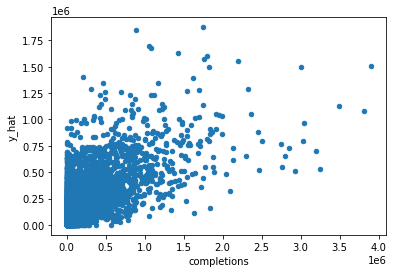

In [80]:
df_error_con["MSE"] = (df_error_con.completions - df_error_con.y_hat)**2
print(df_error_con["MSE"].sum()/df_error_con["MSE"].count())
df_error_con.plot.scatter(x='completions', y='y_hat')

3.6291706141007214e-05


<AxesSubplot:xlabel='vacpercentptchg', ylabel='y_hat'>

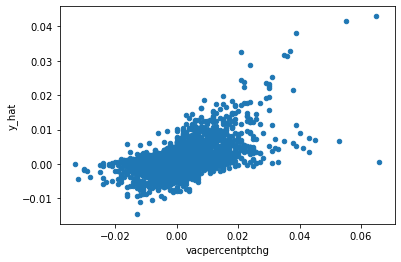

In [81]:
df_error_vac["MSE"] = (df_error_vac.vacpercentptchg - df_error_vac.y_hat)**2
print(df_error_vac["MSE"].sum()/df_error_vac["MSE"].count())
df_error_vac.plot.scatter(x='vacpercentptchg', y='y_hat')

4.799230777244902e-05


<AxesSubplot:xlabel='marketrentpctchange', ylabel='y_hat'>

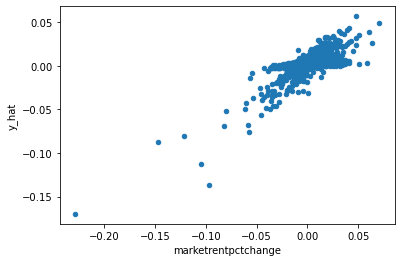

In [82]:
df_error_rent["MSE"] = (df_error_rent.marketrentpctchange - df_error_rent.y_hat)**2
print(df_error_rent["MSE"].sum()/df_error_rent["MSE"].count())
df_error_rent.plot.scatter(x='marketrentpctchange', y='y_hat')

1.6715145172128047e-05


<AxesSubplot:xlabel='gap', ylabel='y_hat'>

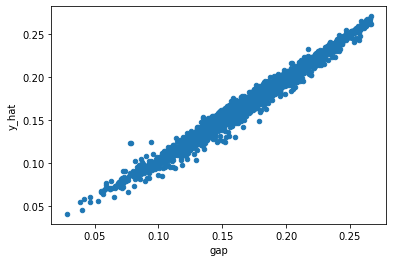

In [84]:
df_error_gap["MSE"] = (df_error_gap.gap - df_error_gap.y_hat)**2
print(df_error_gap["MSE"].sum()/df_error_gap["MSE"].count())
df_error_gap.plot.scatter(x='gap', y='y_hat')

In [88]:
## Submarket Market history summary
df_submarket_yr = submarkettrend[(submarkettrend.sector==sector ) & (submarkettrend.quarter!=5 )][['metrocode', 'subid', 'year','quarter']].groupby(['metrocode', 'subid']).min().reset_index()
print('Number of submarket by starting year.')
print(df_submarket_yr.groupby("year").count()) 
list = df_submarket_yr[df_submarket_yr['year']>2018]
list

Number of submarket by starting year.
        metrocode  subid  quarter
year                             
1999.0        445    445      445
2000.0        164    164      164
2001.0         11     11       11
2002.0          2      2        2
2005.0          9      9        9
2007.0         98     98       98
2011.0        113    113      113
2019.0          4      4        4


,metrocode,subid,year,quarter
178,CR,12,2019.0,1.0
331,HO,16,2019.0,1.0
568,PA,2,2019.0,1.0
663,SA,6,2019.0,1.0


In [90]:
# Divide submarkets into four categories based on data availability
submarkettrend["category"]=np.where(submarkettrend['effrentdollars'].isnull(),0, 1) 
sub_list = submarkettrend[(submarkettrend.sector==sector)][['metrocode', "subid", "category"]].drop_duplicates()
sub_list = sub_list.groupby(["metrocode","subid"], as_index=False).max('category')

sub_list['category'] = np.where((sub_list['metrocode'] == "CR") & (sub_list['subid'] == 12),"start in 2019",sub_list['category'])
sub_list['category'] = np.where((sub_list['metrocode'] == "HO") & (sub_list['subid'] == 16),"start in 2019",sub_list['category'])
sub_list['category'] = np.where((sub_list['metrocode'] == "PA") & (sub_list['subid'] == 2),"start in 2019",sub_list['category'])
sub_list['category'] = np.where((sub_list['metrocode'] == "SA") & (sub_list['subid'] == 6),"start in 2019",sub_list['category'])

sub_list['category'] = np.where((sub_list['metrocode'] == "BY"),"strange",sub_list['category'])
sub_list['category'] = np.where((sub_list['metrocode'] == "QN"),"strange",sub_list['category'])

sub_list_1 = sub_list[sub_list['category']=='0']
sub_list_2 = sub_list[sub_list['category']=='1']

sub_list.to_csv('/home/central/KF_XL_SY/sub_list_XL.csv', index = False)
sub_list.groupby('category').count()

,metrocode,subid
category,,
0,207,207
1,631,631
start in 2019,4,4
strange,4,4


In [312]:
# Estimate models for submarkets. 
# We forecasted the next ten years in previous version, and the code didn't cause any error.
# sub_list_1 does not have effective rents

for row in range(len(sub_list_1.to_dict("split")["data"])):
    metro = sub_list_1.to_dict("split")["data"][row][0]
    subid = sub_list_1.to_dict("split")["data"][row][1]

    df_HE = pd.DataFrame(df_offhet[(df_offhet.MSA==metro) & (df_offhet.Geosub==subid) & (df_offhet.H_E=="H")].groupby(['Year','Qtr']).Size.sum().reset_index())
    df_HE = df_HE.rename(columns={"Size": "H"})
    temp = pd.DataFrame(df_offhet[(df_offhet.MSA==metro) & (df_offhet.Geosub==subid) & (df_offhet.H_E=="E")].groupby(['Year','Qtr']).Size.sum().reset_index())
    temp = temp.rename(columns={"Size": "E"})
    df_HE = df_HE.merge(temp, on = ['Year','Qtr'], how='outer')
    df_HE = df_HE.sort_values(['Year', 'Qtr'])

# Format data for modeling
    df = submarkettrend[(submarkettrend.metrocode==metro) & (submarkettrend.subid==subid) & (submarkettrend.sector==sector)]
    df = df[(df.quarter!=5) & (df.totalmonths).isnull()].dropna(how='all', axis = 1)  # select quarterly data
    df['marketrentpctchange'] = df.marketrentpctchange/100
    #df['effrentpchange'] = df.effrentpchange/100
    df['vacpercent'] = df.vacpercent/100
    df['vacpercentptchg'] = df.vacpercentptchg/100
    
    df_ecca = df_rfa.merge(df_gdp, on = ['metcode', 'yr', 'qtr'],how = 'left')
    df_ecca = df_ecca.merge(df_ecca_US, left_on = ['yr', 'qtr'], right_on = ['YR', 'QTR'],how = 'left')
    df = df.merge(df_ecca[(df_ecca.metcode==metro) & (df_rfa.qtr!=5)], left_on=['metrocode', 'year', 'quarter'], right_on=['metcode', 'yr', 'qtr'], how='right' )
    df = df.merge(df_HE, left_on=['yr', 'qtr'], right_on=['Year', 'Qtr'], how = 'left')
    df.loc[(df.H.isna()) & (df.yr < curryr+3), 'H'] = 0
    df.loc[(df.H.isna()) & (df.yr >= curryr+3), 'H'] = df.completions.mean()
    df['qfhpnr'] = df['qfhpnr'].shift(permit_lag_yr*4)
    df['pop_young'] = df['qfpop2024q'] + df['qfpop2529q']
    df['pop_young'] = df['pop_young'].pct_change(fill_method=None)
    df['qfhx1med'] = df['qfhx1med'].pct_change(fill_method=None)
    
    yr_earlist = df[df.metrocode.notna()].year.min()
    df = df[(df.yr >= yr_earlist ) & (df.yr<= curryr + 10)]
    df = df[(df.yr > yr_earlist) | (df.qtr==4)]
    df['Month'] = df.qtr*3
    df['time'] = pd.to_datetime(df['yr'].astype(int).astype(str)  + df['Month'].astype(int).astype(str), format='%Y%m') 

    df= df.sort_values(['yr', 'qtr'])
    df = df[df.yr <= forecast_end_yr]
# for i in ['metcode', 'state', 'cbsa', 'longmet', 'region', 'yr', 'qtr', 'VINTAGE']:
#          del df[i] # preparing data table for analysis

    df_copy = df.copy()

## Transform all level data to percentage change
    df['inv_chg'] = df.inventory.pct_change(fill_method=None).shift()
    df['inv_lag'] = df['inventory'].shift()    
    df['completions_lag'] = df['completions'].shift()

### calculate z-scores
    cols = ['gdp',  'qfet', 'offemp', 'YIELD12M', 'CREPIOFF']
    for col in cols:
        col_zscore = col + '_zscore'
        df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    df = df.replace([np.inf, -np.inf], 0)

## Select Variables
    X_REIS = ['inv_lag','completions_lag']
    X_ECCA = ['gdp_zscore',  'qfet_zscore', 'YIELD12M_zscore', 'CREPIOFF_zscore']
    X_select = X_REIS + X_ECCA
    
# Create training set and testing set
    df_training = df[df.yr <= yr_training][X_select + ['completions']]
    df_training = df_training.dropna(axis=0, how='any')
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', 'H']
    df_testing = df[(df.yr >= testing_yr_begin) & (df.yr <= 2019)][col_export + X_select + ['completions']]
    df_testing = df_testing.dropna(axis=0, how='any')
    y = df_training.completions
    X = df_training[X_select]

## Estimate Ridge Model
    tscv = TimeSeriesSplit(n_splits=4)
    clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
        alphas=np.logspace(-8, 0, 20))
#         clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
#             alphas=np.logspace(-8, 0, 20))
    X = df_training[X_select]
    X_list = X_select
    clf.fit(X,y)
    
    try: 
        Coef_table_con
    except NameError: 
        Coef_table_con = pd.DataFrame (list(X.columns) + ["Intercept"],columns=['Variables'])
        
    Coef_table_con[metro+'_'+str(subid)] = ndarray.tolist(clf.coef_) + [clf.intercept_]
    
    output = open('/home/central/KF_XL_SY/Model_off/con_' + metro+'_'+str(int(subid)) +'.pkl', 'wb')
    dill.dump(clf, output)
    output.close()
#     print(clf.coef_)

# Use H stock to fill the coming 8 quarters
    #con =  (df.completions.isna()) & (df.time>= str(curryr) + "-" + str(currqtr*3)) & (df.time< str(curryr+2) + "-" + str(currqtr*3))
    #df.loc[con, 'completions'] = df[con].H.astype('float')

    #n=1
    #while n <=8:
        #df.loc[(df.time>= str(curryr) + "-" + str(currqtr*3)), 'inventory'] = df[(df.time>= str(curryr) + "-" + str(currqtr*3))].inv_lag + df[(df.time>= str(curryr) + "-" + str(currqtr*3))].completions
        #df['inv_lag'] = df['inventory'].shift() 
        #n = n+1
    #df['inv_chg'] = df.inventory.pct_change(fill_method=None).shift()
    #df['completions_lag'] = df['completions'].shift()

    #try:
        #while df[df.yr >curryr-1].completions.isna().sum()>0:
            #df.loc[(df.completions.isna()) & (df.yr >2015) & (df.inv_lag.notna()), 'completions'] =clf.predict(df[(df.completions.isna()) & (df.yr >2015) & (df.inv_lag.notna())][X_list])
            #df.loc[df.completions < 10000, "completions"] = 0.
            #df.loc[(df.inventory.isna()) & (df.inv_lag.notna()), 'inventory'] = df[(df.inventory.isna()) & (df.inv_lag.notna())].inv_lag + df[(df.inventory.isna()) & (df.inv_lag.notna())].completions
            #df['inv_lag'] = df['inventory'].shift()   
            #df['inv_chg'] = df.inventory.pct_change(fill_method=None).shift()
            #df['completions_lag'] = df['completions'].shift()
    #except:
        #print(metro, "Something in the construction forecast went wrong")

#in-sample testing file
    df_testing['y_hat'] = clf.predict(df_testing[X_list]) 
    df_testing['y_hat'] = np.where(df_testing['y_hat']<10000, 0, df_testing['y_hat'])
    
    try: 
        df_error_con
    except NameError: 
        df_error_con = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', 'y_hat', "completions", 'H']
    df_error_con = pd.concat([df_error_con,  df_testing[col_export]])

#forecast 2018 and 2019 using historical data
    df_try = df
    df_try = df_try[df_try.yr<=2019]
    
    df_try.loc[df_try.yr>2017,'inventory']=float('NaN')
    df_try.loc[df_try.yr>2017,'inventorypct_chg']=float('NaN')
    df_try.loc[df_try.yr>2017,'completions']=float('NaN')
    df_try.loc[df_try.yr>2017,'vacantstock']=float('NaN')
    df_try.loc[df_try.yr>2017,'vacpercent']=float('NaN')
    df_try.loc[df_try.yr>2017,'vacpercentptchg']=float('NaN')
    df_try.loc[df_try.yr>2017,'occupiedstock']=float('NaN')
    df_try.loc[df_try.yr>2017,'netabsorption']=float('NaN')
    df_try.loc[df_try.yr>2017,'marketrentdollars']=float('NaN')
    df_try.loc[df_try.yr>2017,'marketrentpctchange']=float('NaN')

    df_try['inv_chg'] = df_try.inventory.pct_change(fill_method=None).shift()
    df_try['inv_lag'] = df_try['inventory'].shift()    
    df_try['completions_lag'] = df_try['completions'].shift()

    try:
        while df_try[df_try.yr >2017].completions.isna().sum()>0:
            df_try.loc[(df_try.completions.isna()) & (df_try.yr >2015) & (df_try.inv_lag.notna()), 'completions'] =clf.predict(df_try[(df_try.completions.isna()) & (df_try.yr >2015) & (df_try.inv_lag.notna())][X_list])
            df_try.loc[df_try.completions < 10000, "completions"] = 0.
            df_try.loc[(df_try.inventory.isna()) & (df_try.inv_lag.notna()), 'inventory'] = df_try[(df_try.inventory.isna()) & (df_try.inv_lag.notna())].inv_lag + df_try[(df_try.inventory.isna()) & (df_try.inv_lag.notna())].completions
            df_try['inv_lag'] = df_try['inventory'].shift()   
            df_try['inv_chg'] = df_try.inventory.pct_change(fill_method=None).shift()
            df_try['completions_lag'] = df_try['completions'].shift()
    except:
        print(metro, "Something in the construction forecast went wrong")
    
    try: 
        df_try_con
    except NameError: 
        df_try_con = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', "completions"]
    df_try_con = pd.concat([df_try_con,  df_try[col_export]])
    df_try_con = df_try_con[df_try_con.year>=2018]
    
# Estimate Vacancy Model (Hendershott 2009)
## Prepare data
    df['qfet_ln_diff'] = np.log(df['qfet']).diff()
    df['qfet_ln_diff_lag'] = np.log(df['qfet']).diff().shift()
    df['qfet_ln_diff_lag2'] = np.log(df['qfet']).diff().shift(2)
    df['USGDP_ln_diff'] = df['USGDP'].pct_change(periods=4)
    df['USGDP_ln_diff_lag'] = df['USGDP'].pct_change(periods=4).shift()

    df['inv_ln_diff'] = np.log(df['inventory']).diff()
    df['vac_lag'] = (df.vacpercent).shift()
    df['vacpercentptchg_lag'] = (df.vacpercentptchg).shift()
## Select Variables
    X_REIS = ['inv_ln_diff', 'vac_lag','vacpercentptchg_lag']
# X_ECCA = ['qfet_ln_diff', 'qfhholdq_ln_diff']
    X_ECCA = ['qfet_ln_diff', 'qfet_ln_diff_lag', 'qfet_ln_diff_lag2', 'USGDP_ln_diff', 'USGDP_ln_diff_lag']
    X_select = X_REIS + X_ECCA

# Create training set and testing set
    df_training = df[df.yr <= yr_training][X_select + ['vacpercentptchg']]
    df_training = df_training.dropna(axis=0, how='any')
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter']
    df_testing = df[(df.yr >= testing_yr_begin) & (df.yr <= 2019)][col_export + X_select + ['vacpercentptchg']]
    df_testing = df_testing.dropna(axis=0, how='any')
    y = df_training.vacpercentptchg
    X = df_training[X_select]

## Estimate Ridge Model
    tscv = TimeSeriesSplit(n_splits=4)
    clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
        alphas=np.logspace(-8, 0, 20))
#         clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
#             alphas=np.logspace(-8, 0, 20))
    X = df_training[X_select]
    X_list = X_select
    clf.fit(X,y)
    
    try: 
        Coef_table_vac
    except NameError: 
        Coef_table_vac = pd.DataFrame (list(X.columns) + ["Intercept"],columns=['Variables'])
    Coef_table_vac[metro+'_'+str(subid)] = ndarray.tolist(clf.coef_) + [clf.intercept_]
    
    output = open('/home/central/KF_XL_SY/Model_off/vac_' + metro+'_'+str(int(subid)) +'.pkl', 'wb')
    dill.dump(clf, output)
    output.close()
#     print(clf.coef_)
    
    #try:
        #while df[df.yr >curryr-1].vacpercentptchg.isna().sum()>0:
            #df.loc[(df.vacpercentptchg.isna()) & (df.yr >2015) & (df.vac_lag.notna()), 'vacpercentptchg'] = (clf.predict(df[(df.vacpercentptchg.isna()) & (df.yr >2015) & (df.vac_lag.notna())][X_list]))
            #df.loc[(df.vacpercent.isna()) & (df.vac_lag.notna()), 'vacpercent'] = df[(df.vacpercent.isna()) & (df.vac_lag.notna())].vac_lag + df[(df.vacpercent.isna()) & (df.vac_lag.notna())].vacpercentptchg
            #df['vac_lag'] = (df.vacpercent).shift()  
            #df['vacpercentptchg_lag'] = (df.vacpercentptchg).shift()
    #except:
        #print(metro, "Something in the vacancy forecast went wrong")
   
    #in-sample testing
    df_testing['y_hat'] = clf.predict(df_testing[X_list]) 
    
    try: 
        df_error_vac
    except NameError: 
        df_error_vac = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', 'y_hat', "vacpercentptchg"]
    df_error_vac = pd.concat([df_error_vac,  df_testing[col_export]])

    #forecast 2018 and 2019 using historical data
    df_try['qfet_ln_diff'] = np.log(df_try['qfet']).diff()
    df_try['qfet_ln_diff_lag'] = np.log(df_try['qfet']).diff().shift()
    df_try['qfet_ln_diff_lag2'] = np.log(df_try['qfet']).diff().shift(2)
    df_try['USGDP_ln_diff'] = df_try['USGDP'].pct_change(periods=4)
    df_try['USGDP_ln_diff_lag'] = df_try['USGDP'].pct_change(periods=4).shift()
    
    df_try['inv_ln_diff'] = np.log(df_try['inventory']).diff()
    df_try['vac_lag'] = (df_try.vacpercent).shift()
    df_try['vacpercentptchg_lag'] = (df_try.vacpercentptchg).shift()
    
    try:
        while df_try[df_try.yr >2017].vacpercentptchg.isna().sum()>0:
            df_try.loc[(df_try.vacpercentptchg.isna()) & (df_try.yr >2015) & (df_try.vac_lag.notna()), 'vacpercentptchg'] = (clf.predict(df_try[(df_try.vacpercentptchg.isna()) & (df_try.yr >2015) & (df_try.vac_lag.notna())][X_list]))
            df_try.loc[(df_try.vacpercent.isna()) & (df_try.vac_lag.notna()), 'vacpercent'] = df_try[(df_try.vacpercent.isna()) & (df_try.vac_lag.notna())].vac_lag + df_try[(df_try.vacpercent.isna()) & (df_try.vac_lag.notna())].vacpercentptchg
            df_try['vac_lag'] = (df_try.vacpercent).shift()  
            df_try['vacpercentptchg_lag'] = (df_try.vacpercentptchg).shift()
    except:
        print(metro, "Something in the vacancy forecast went wrong")

    try: 
        df_try_vac
    except NameError: 
        df_try_vac = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', "vacpercentptchg"]
    df_try_vac = pd.concat([df_try_vac,  df_try[col_export]])
    df_try_vac = df_try_vac[df_try_vac.year>=2018]

# Estimate Rent Model (Hendershott 2002)
## Prepare data
    df['qfet_ln_diff'] = np.log(df['qfet']).diff()
    df['qfet_ln_lag'] = np.log(df['qfet']).shift()
    df['qfypq_ln_diff'] = np.log(df['qfypq']).diff()

    df['inv_ln_diff'] = np.log(df['inventory']).diff()
    df['inv_ln_lag'] = np.log(df['inventory']).shift()
    df['occ_ln_lag'] = np.log(1- df.vacpercent).shift()
    df['occ_ln_diff'] = np.log(1- df.vacpercent).diff()
    df['marketrentdollars_ln_lag'] = np.log(df['marketrentdollars']).shift()
    df['marketrentpctchange_lag'] = (df.marketrentpctchange).shift()

    df['USGDP_ln_diff'] = df['USGDP'].pct_change(periods=4)
    df['USGDP_ln_diff_lag'] = df['USGDP'].pct_change(periods=4).shift()
    
## Asking Rent
## Select Variables
    X_REIS = ['inv_ln_diff', 'occ_ln_diff', 'marketrentpctchange_lag']
    X_ECCA = ['qfet_ln_diff','qfet_ln_lag', 'USGDP_ln_diff', 'USGDP_ln_diff_lag']
    X_select = X_REIS + X_ECCA
    
# Create training set and testing set
    df_training = df[df.yr <= yr_training][X_select + ['marketrentpctchange']]
    df_training = df_training.dropna(axis=0, how='any')
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter']
    df_testing = df[(df.yr >= testing_yr_begin) & (df.yr <= 2019)][col_export + X_select + ['marketrentpctchange']]
    df_testing = df_testing.dropna(axis=0, how='any')
    y = df_training.marketrentpctchange
    X = df_training[X_select]

## Estimate Ridge Model
    tscv = TimeSeriesSplit(n_splits=4)
    clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
        alphas=np.logspace(-8, 0, 20))
#         clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
#             alphas=np.logspace(-8, 0, 20))
    X = df_training[X_select]
    X_list = X_select
    clf.fit(X,y)
    
    try: 
        Coef_table_rent
    except NameError: 
        Coef_table_rent = pd.DataFrame (list(X.columns) + ["Intercept"],columns=['Variables'])
    Coef_table_rent[metro+'_'+str(subid)] = ndarray.tolist(clf.coef_) + [clf.intercept_]

    output = open('/home/central/KF_XL_SY/Model_off/rent_' + metro+'_'+str(int(subid)) +'.pkl', 'wb')
    dill.dump(clf, output)
    output.close()
#     print(clf.coef_)

    #try:
        #while df[df.yr >curryr-1].marketrentpctchange.isna().sum()>0:
            #df.loc[(df.marketrentpctchange.isna()) & (df.yr >2015) & (df.marketrentdollars_ln_lag.notna()), 'marketrentpctchange'] = (clf.predict(df[(df.marketrentpctchange.isna()) & (df.yr >2015) & (df.marketrentdollars_ln_lag.notna())][X_list]))
            #df['marketrentdollars_lag'] = df['marketrentdollars'].shift()
            #df.loc[df.marketrentdollars.isna(),'marketrentdollars'] = df[df.marketrentdollars.isna()]['marketrentdollars_lag'] * (1+df[df.marketrentdollars.isna()].marketrentpctchange)
            #df['marketrentdollars_ln_lag'] = np.log(df['marketrentdollars']).shift()
            #df['marketrentpctchange_lag'] = (df.marketrentpctchange).shift()

    #except:
        #print(metro, "Something in the asking rent forecast went wrong")

# In-sample testing
    df_testing['y_hat'] = clf.predict(df_testing[X_list]) 
    
    try: 
        df_error_rent
    except NameError: 
        df_error_rent = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', 'y_hat', "marketrentpctchange"]
    df_error_rent = pd.concat([df_error_rent,  df_testing[col_export]])

# forecast 2018 and 2019 using historical data
    df_try['qfet_ln_diff'] = np.log(df_try['qfet']).diff()
    df_try['qfet_ln_lag'] = np.log(df_try['qfet']).shift()
    df_try['qfypq_ln_diff'] = np.log(df_try['qfypq']).diff()

    df_try['inv_ln_diff'] = np.log(df_try['inventory']).diff()
    df_try['inv_ln_lag'] = np.log(df_try['inventory']).shift()
    df_try['occ_ln_lag'] = np.log(1- df_try.vacpercent).shift()
    df_try['occ_ln_diff'] = np.log(1- df_try.vacpercent).diff()
    df_try['marketrentdollars_ln_lag'] = np.log(df_try['marketrentdollars']).shift()
    df_try['marketrentpctchange_lag'] = (df_try.marketrentpctchange).shift()

    df_try['USGDP_ln_diff'] = df_try['USGDP'].pct_change(periods=4)
    df_try['USGDP_ln_diff_lag'] = df_try['USGDP'].pct_change(periods=4).shift()
    
    try:
        while df_try[df_try.yr >2017].marketrentpctchange.isna().sum()>0:
            df_try.loc[(df_try.marketrentpctchange.isna()) & (df_try.yr >2015) & (df_try.marketrentdollars_ln_lag.notna()), 'marketrentpctchange'] = (clf.predict(df_try[(df_try.marketrentpctchange.isna()) & (df_try.yr >2015) & (df_try.marketrentdollars_ln_lag.notna())][X_list]))
            df_try['marketrentdollars_lag'] = df_try['marketrentdollars'].shift()
            df_try.loc[df_try.marketrentdollars.isna(),'marketrentdollars'] = df_try[df_try.marketrentdollars.isna()]['marketrentdollars_lag'] * (1+df_try[df_try.marketrentdollars.isna()].marketrentpctchange)
            df_try['marketrentdollars_ln_lag'] = np.log(df_try['marketrentdollars']).shift()
            df_try['marketrentpctchange_lag'] = (df_try.marketrentpctchange).shift()

    except:
        print(metro, "Something in the asking rent forecast went wrong")
    
    try: 
        df_try_rent
    except NameError: 
        df_try_rent = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', "marketrentpctchange"]
    df_try_rent = pd.concat([df_try_rent,  df_try[col_export]])   
    df_try_rent = df_try_rent[df_try_rent.year>=2018]

In [ ]:
# Estimate models for submarkets. 
# We forecasted the next ten years in previous version, and the code didn't cause any error.
# sub_list_2 includes gap forecasting

for row in range(len(sub_list_2.to_dict("split")["data"])):
    metro = sub_list_2.to_dict("split")["data"][row][0]
    subid = sub_list_2.to_dict("split")["data"][row][1]

    df_HE = pd.DataFrame(df_offhet[(df_offhet.MSA==metro) & (df_offhet.Geosub==subid) & (df_offhet.H_E=="H")].groupby(['Year','Qtr']).Size.sum().reset_index())
    df_HE = df_HE.rename(columns={"Size": "H"})
    temp = pd.DataFrame(df_offhet[(df_offhet.MSA==metro) & (df_offhet.Geosub==subid) & (df_offhet.H_E=="E")].groupby(['Year','Qtr']).Size.sum().reset_index())
    temp = temp.rename(columns={"Size": "E"})
    df_HE = df_HE.merge(temp, on = ['Year','Qtr'], how='outer')
    df_HE = df_HE.sort_values(['Year', 'Qtr'])

# Format data for modeling
    df = submarkettrend[(submarkettrend.metrocode==metro) & (submarkettrend.subid==subid) & (submarkettrend.sector==sector)]
    df = df[(df.quarter!=5) & (df.totalmonths).isnull()].dropna(how='all', axis = 1)  # select quarterly data
    df['marketrentpctchange'] = df.marketrentpctchange/100
    df['effrentpchange'] = df.effrentpchange/100
    df['vacpercent'] = df.vacpercent/100
    df['vacpercentptchg'] = df.vacpercentptchg/100
    
    df_ecca = df_rfa.merge(df_gdp, on = ['metcode', 'yr', 'qtr'],how = 'left')
    df_ecca = df_ecca.merge(df_ecca_US, left_on = ['yr', 'qtr'], right_on = ['YR', 'QTR'],how = 'left')
    df = df.merge(df_ecca[(df_ecca.metcode==metro) & (df_rfa.qtr!=5)], left_on=['metrocode', 'year', 'quarter'], right_on=['metcode', 'yr', 'qtr'], how='right' )
    df = df.merge(df_HE, left_on=['yr', 'qtr'], right_on=['Year', 'Qtr'], how = 'left')
    df.loc[(df.H.isna()) & (df.yr < curryr+3), 'H'] = 0
    df.loc[(df.H.isna()) & (df.yr >= curryr+3), 'H'] = df.completions.mean()
    df['qfhpnr'] = df['qfhpnr'].shift(permit_lag_yr*4)
    df['pop_young'] = df['qfpop2024q'] + df['qfpop2529q']
    df['pop_young'] = df['pop_young'].pct_change(fill_method=None)
    df['qfhx1med'] = df['qfhx1med'].pct_change(fill_method=None)
    
    yr_earlist = df[df.metrocode.notna()].year.min()
    df = df[(df.yr >= yr_earlist ) & (df.yr<= curryr + 10)]
    df = df[(df.yr > yr_earlist) | (df.qtr==4)]
    df['Month'] = df.qtr*3
    df['time'] = pd.to_datetime(df['yr'].astype(int).astype(str)  + df['Month'].astype(int).astype(str), format='%Y%m') 

    df= df.sort_values(['yr', 'qtr'])
    df = df[df.yr <= forecast_end_yr]
# for i in ['metcode', 'state', 'cbsa', 'longmet', 'region', 'yr', 'qtr', 'VINTAGE']:
#          del df[i] # preparing data table for analysis

    df_copy = df.copy()

## Transform all level data to percentage change
    df['inv_chg'] = df.inventory.pct_change(fill_method=None).shift()
    df['inv_lag'] = df['inventory'].shift()    
    df['completions_lag'] = df['completions'].shift()

### calculate z-scores
    cols = ['gdp',  'qfet', 'offemp', 'YIELD12M', 'CREPIOFF']
    for col in cols:
        col_zscore = col + '_zscore'
        df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    df = df.replace([np.inf, -np.inf], 0)

## Select Variables
    X_REIS = ['inv_lag','completions_lag']
    X_ECCA = ['gdp_zscore',  'qfet_zscore', 'YIELD12M_zscore', 'CREPIOFF_zscore']
    X_select = X_REIS + X_ECCA
    
# Create training set and testing set
    df_training = df[df.yr <= yr_training][X_select + ['completions']]
    df_training = df_training.dropna(axis=0, how='any')
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', 'H']
    df_testing = df[(df.yr >= testing_yr_begin) & (df.yr <= 2019)][col_export + X_select + ['completions']]
    df_testing = df_testing.dropna(axis=0, how='any')
    y = df_training.completions
    X = df_training[X_select]

## Estimate Ridge Model
    tscv = TimeSeriesSplit(n_splits=4)
    clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
        alphas=np.logspace(-8, 0, 20))
#         clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
#             alphas=np.logspace(-8, 0, 20))
    X = df_training[X_select]
    X_list = X_select
    clf.fit(X,y)
    
    try: 
        Coef_table_con
    except NameError: 
        Coef_table_con = pd.DataFrame (list(X.columns) + ["Intercept"],columns=['Variables'])
        
    Coef_table_con[metro+'_'+str(subid)] = ndarray.tolist(clf.coef_) + [clf.intercept_]
    
    output = open('/home/central/KF_XL_SY/Model_off/con_' + metro+'_'+str(int(subid)) +'.pkl', 'wb')
    dill.dump(clf, output)
    output.close()
#     print(clf.coef_)

# Use H stock to fill the coming 8 quarters
    #con =  (df.completions.isna()) & (df.time>= str(curryr) + "-" + str(currqtr*3)) & (df.time< str(curryr+2) + "-" + str(currqtr*3))
    #df.loc[con, 'completions'] = df[con].H.astype('float')

    #n=1
    #while n <=8:
        #df.loc[(df.time>= str(curryr) + "-" + str(currqtr*3)), 'inventory'] = df[(df.time>= str(curryr) + "-" + str(currqtr*3))].inv_lag + df[(df.time>= str(curryr) + "-" + str(currqtr*3))].completions
        #df['inv_lag'] = df['inventory'].shift() 
        #n = n+1
    #df['inv_chg'] = df.inventory.pct_change(fill_method=None).shift()
    #df['completions_lag'] = df['completions'].shift()

    #try:
        #while df[df.yr >curryr-1].completions.isna().sum()>0:
            #df.loc[(df.completions.isna()) & (df.yr >2015) & (df.inv_lag.notna()), 'completions'] =clf.predict(df[(df.completions.isna()) & (df.yr >2015) & (df.inv_lag.notna())][X_list])
            #df.loc[df.completions < 0, "completions"] = 0.
            #df.loc[(df.inventory.isna()) & (df.inv_lag.notna()), 'inventory'] = df[(df.inventory.isna()) & (df.inv_lag.notna())].inv_lag + df[(df.inventory.isna()) & (df.inv_lag.notna())].completions
            #df['inv_lag'] = df['inventory'].shift()   
            #df['inv_chg'] = df.inventory.pct_change(fill_method=None).shift()
            #df['completions_lag'] = df['completions'].shift()
    #except:
        #print(metro, "Something in the construction forecast went wrong")

#in-sample testing file
    df_testing['y_hat'] = clf.predict(df_testing[X_list]) 
    df_testing['y_hat'] = np.where(df_testing['y_hat']<10000, 0, df_testing['y_hat'])
    
    try: 
        df_error_con
    except NameError: 
        df_error_con = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', 'y_hat', "completions", 'H']
    df_error_con = pd.concat([df_error_con,  df_testing[col_export]])

#forecast 2018 and 2019 using historical data
    df_try = df
    df_try = df_try[df_try.yr<=2019]
    
    df_try.loc[df_try.yr>2017,'inventory']=float('NaN')
    df_try.loc[df_try.yr>2017,'inventorypct_chg']=float('NaN')
    df_try.loc[df_try.yr>2017,'completions']=float('NaN')
    df_try.loc[df_try.yr>2017,'vacantstock']=float('NaN')
    df_try.loc[df_try.yr>2017,'vacpercent']=float('NaN')
    df_try.loc[df_try.yr>2017,'vacpercentptchg']=float('NaN')
    df_try.loc[df_try.yr>2017,'occupiedstock']=float('NaN')
    df_try.loc[df_try.yr>2017,'netabsorption']=float('NaN')
    df_try.loc[df_try.yr>2017,'marketrentdollars']=float('NaN')
    df_try.loc[df_try.yr>2017,'marketrentpctchange']=float('NaN')
    df_try.loc[df_try.yr>2017,'effrentdollars']=float('NaN')

    df_try['inv_chg'] = df_try.inventory.pct_change(fill_method=None).shift()
    df_try['inv_lag'] = df_try['inventory'].shift()    
    df_try['completions_lag'] = df_try['completions'].shift()

    try:
        while df_try[df_try.yr >2017].completions.isna().sum()>0:
            df_try.loc[(df_try.completions.isna()) & (df_try.yr >2015) & (df_try.inv_lag.notna()), 'completions'] =clf.predict(df_try[(df_try.completions.isna()) & (df_try.yr >2015) & (df_try.inv_lag.notna())][X_list])
            df_try.loc[df_try.completions < 10000, "completions"] = 0.
            df_try.loc[(df_try.inventory.isna()) & (df_try.inv_lag.notna()), 'inventory'] = df_try[(df_try.inventory.isna()) & (df_try.inv_lag.notna())].inv_lag + df_try[(df_try.inventory.isna()) & (df_try.inv_lag.notna())].completions
            df_try['inv_lag'] = df_try['inventory'].shift()   
            df_try['inv_chg'] = df_try.inventory.pct_change(fill_method=None).shift()
            df_try['completions_lag'] = df_try['completions'].shift()
    except:
        print(metro, "Something in the construction forecast went wrong")
    
    try: 
        df_try_con
    except NameError: 
        df_try_con = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', "completions"]
    df_try_con = pd.concat([df_try_con,  df_try[col_export]])
    df_try_con = df_try_con[df_try_con.year>=2018]
    
# Estimate Vacancy Model (Hendershott 2009)
## Prepare data
    df['qfet_ln_diff'] = np.log(df['qfet']).diff()
    df['qfet_ln_diff_lag'] = np.log(df['qfet']).diff().shift()
    df['qfet_ln_diff_lag2'] = np.log(df['qfet']).diff().shift(2)
    df['USGDP_ln_diff'] = df['USGDP'].pct_change(periods=4)
    df['USGDP_ln_diff_lag'] = df['USGDP'].pct_change(periods=4).shift()

    df['inv_ln_diff'] = np.log(df['inventory']).diff()
    df['vac_lag'] = (df.vacpercent).shift()
    df['vacpercentptchg_lag'] = (df.vacpercentptchg).shift()
## Select Variables
    X_REIS = ['inv_ln_diff', 'vac_lag','vacpercentptchg_lag']
# X_ECCA = ['qfet_ln_diff', 'qfhholdq_ln_diff']
    X_ECCA = ['qfet_ln_diff', 'qfet_ln_diff_lag', 'qfet_ln_diff_lag2', 'USGDP_ln_diff', 'USGDP_ln_diff_lag']
    X_select = X_REIS + X_ECCA

# Create training set and testing set
    df_training = df[df.yr <= yr_training][X_select + ['vacpercentptchg']]
    df_training = df_training.dropna(axis=0, how='any')
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter']
    df_testing = df[(df.yr >= testing_yr_begin) & (df.yr <= 2019)][col_export + X_select + ['vacpercentptchg']]
    df_testing = df_testing.dropna(axis=0, how='any')
    y = df_training.vacpercentptchg
    X = df_training[X_select]

## Estimate Ridge Model
    tscv = TimeSeriesSplit(n_splits=4)
    clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
        alphas=np.logspace(-8, 0, 20))
#         clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
#             alphas=np.logspace(-8, 0, 20))
    X = df_training[X_select]
    X_list = X_select
    clf.fit(X,y)
    
    try: 
        Coef_table_vac
    except NameError: 
        Coef_table_vac = pd.DataFrame (list(X.columns) + ["Intercept"],columns=['Variables'])
    Coef_table_vac[metro+'_'+str(subid)] = ndarray.tolist(clf.coef_) + [clf.intercept_]
    
    output = open('/home/central/KF_XL_SY/Model_off/vac_' + metro+'_'+str(int(subid)) +'.pkl', 'wb')
    dill.dump(clf, output)
    output.close()
#     print(clf.coef_)
    
    #try:
        #while df[df.yr >curryr-1].vacpercentptchg.isna().sum()>0:
            #df.loc[(df.vacpercentptchg.isna()) & (df.yr >2015) & (df.vac_lag.notna()), 'vacpercentptchg'] = (clf.predict(df[(df.vacpercentptchg.isna()) & (df.yr >2015) & (df.vac_lag.notna())][X_list]))
            #df.loc[(df.vacpercent.isna()) & (df.vac_lag.notna()), 'vacpercent'] = df[(df.vacpercent.isna()) & (df.vac_lag.notna())].vac_lag + df[(df.vacpercent.isna()) & (df.vac_lag.notna())].vacpercentptchg
            #df['vac_lag'] = (df.vacpercent).shift()  
            #df['vacpercentptchg_lag'] = (df.vacpercentptchg).shift()
    #except:
        #print(metro, "Something in the vacancy forecast went wrong")
   
    #in-sample testing
    df_testing['y_hat'] = clf.predict(df_testing[X_list]) 
    
    try: 
        df_error_vac
    except NameError: 
        df_error_vac = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', 'y_hat', "vacpercentptchg"]
    df_error_vac = pd.concat([df_error_vac,  df_testing[col_export]])

    #forecast 2018 and 2019 using historical data
    df_try['qfet_ln_diff'] = np.log(df_try['qfet']).diff()
    df_try['qfet_ln_diff_lag'] = np.log(df_try['qfet']).diff().shift()
    df_try['qfet_ln_diff_lag2'] = np.log(df_try['qfet']).diff().shift(2)
    df_try['USGDP_ln_diff'] = df_try['USGDP'].pct_change(periods=4)
    df_try['USGDP_ln_diff_lag'] = df_try['USGDP'].pct_change(periods=4).shift()
    
    df_try['inv_ln_diff'] = np.log(df_try['inventory']).diff()
    df_try['vac_lag'] = (df_try.vacpercent).shift()
    df_try['vacpercentptchg_lag'] = (df_try.vacpercentptchg).shift()
    
    try:
        while df_try[df_try.yr >2017].vacpercentptchg.isna().sum()>0:
            df_try.loc[(df_try.vacpercentptchg.isna()) & (df_try.yr >2015) & (df_try.vac_lag.notna()), 'vacpercentptchg'] = (clf.predict(df_try[(df_try.vacpercentptchg.isna()) & (df_try.yr >2015) & (df_try.vac_lag.notna())][X_list]))
            df_try.loc[(df_try.vacpercent.isna()) & (df_try.vac_lag.notna()), 'vacpercent'] = df_try[(df_try.vacpercent.isna()) & (df_try.vac_lag.notna())].vac_lag + df_try[(df_try.vacpercent.isna()) & (df_try.vac_lag.notna())].vacpercentptchg
            df_try['vac_lag'] = (df_try.vacpercent).shift()  
            df_try['vacpercentptchg_lag'] = (df_try.vacpercentptchg).shift()
    except:
        print(metro, "Something in the vacancy forecast went wrong")

    try: 
        df_try_vac
    except NameError: 
        df_try_vac = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', "vacpercentptchg"]
    df_try_vac = pd.concat([df_try_vac,  df_try[col_export]])
    df_try_vac = df_try_vac[df_try_vac.year>=2018]

# Estimate Rent Model (Hendershott 2002)
## Prepare data
    df['qfet_ln_diff'] = np.log(df['qfet']).diff()
    df['qfet_ln_lag'] = np.log(df['qfet']).shift()
    df['qfypq_ln_diff'] = np.log(df['qfypq']).diff()

    df['inv_ln_diff'] = np.log(df['inventory']).diff()
    df['inv_ln_lag'] = np.log(df['inventory']).shift()
    df['occ_ln_lag'] = np.log(1- df.vacpercent).shift()
    df['occ_ln_diff'] = np.log(1- df.vacpercent).diff()
    df['marketrentdollars_ln_lag'] = np.log(df['marketrentdollars']).shift()
    df['marketrentpctchange_lag'] = (df.marketrentpctchange).shift()

    df['USGDP_ln_diff'] = df['USGDP'].pct_change(periods=4)
    df['USGDP_ln_diff_lag'] = df['USGDP'].pct_change(periods=4).shift()
    
## Asking Rent
## Select Variables
    X_REIS = ['inv_ln_diff', 'occ_ln_diff', 'marketrentpctchange_lag']
    X_ECCA = ['qfet_ln_diff','qfet_ln_lag', 'USGDP_ln_diff', 'USGDP_ln_diff_lag']
    X_select = X_REIS + X_ECCA
    
# Create training set and testing set
    df_training = df[df.yr <= yr_training][X_select + ['marketrentpctchange']]
    df_training = df_training.dropna(axis=0, how='any')
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter']
    df_testing = df[(df.yr >= testing_yr_begin) & (df.yr <= 2019)][col_export + X_select + ['marketrentpctchange']]
    df_testing = df_testing.dropna(axis=0, how='any')
    y = df_training.marketrentpctchange
    X = df_training[X_select]

## Estimate Ridge Model
    tscv = TimeSeriesSplit(n_splits=4)
    clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
        alphas=np.logspace(-8, 0, 20))
#         clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
#             alphas=np.logspace(-8, 0, 20))
    X = df_training[X_select]
    X_list = X_select
    clf.fit(X,y)
    
    try: 
        Coef_table_rent
    except NameError: 
        Coef_table_rent = pd.DataFrame (list(X.columns) + ["Intercept"],columns=['Variables'])
    Coef_table_rent[metro+'_'+str(subid)] = ndarray.tolist(clf.coef_) + [clf.intercept_]

    output = open('/home/central/KF_XL_SY/Model_off/rent_' + metro+'_'+str(int(subid)) +'.pkl', 'wb')
    dill.dump(clf, output)
    output.close()
#     print(clf.coef_)

    #try:
        #while df[df.yr >curryr-1].marketrentpctchange.isna().sum()>0:
            #df.loc[(df.marketrentpctchange.isna()) & (df.yr >2015) & (df.marketrentdollars_ln_lag.notna()), 'marketrentpctchange'] = (clf.predict(df[(df.marketrentpctchange.isna()) & (df.yr >2015) & (df.marketrentdollars_ln_lag.notna())][X_list]))
            #df['marketrentdollars_lag'] = df['marketrentdollars'].shift()
            #df.loc[df.marketrentdollars.isna(),'marketrentdollars'] = df[df.marketrentdollars.isna()]['marketrentdollars_lag'] * (1+df[df.marketrentdollars.isna()].marketrentpctchange)
            #df['marketrentdollars_ln_lag'] = np.log(df['marketrentdollars']).shift()
            #df['marketrentpctchange_lag'] = (df.marketrentpctchange).shift()

    #except:
        #print(metro, "Something in the asking rent forecast went wrong")

# In-sample testing
    df_testing['y_hat'] = clf.predict(df_testing[X_list]) 
    
    try: 
        df_error_rent
    except NameError: 
        df_error_rent = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', 'y_hat', "marketrentpctchange"]
    df_error_rent = pd.concat([df_error_rent,  df_testing[col_export]])

# forecast 2018 and 2019 using historical data
    df_try['qfet_ln_diff'] = np.log(df_try['qfet']).diff()
    df_try['qfet_ln_lag'] = np.log(df_try['qfet']).shift()
    df_try['qfypq_ln_diff'] = np.log(df_try['qfypq']).diff()

    df_try['inv_ln_diff'] = np.log(df_try['inventory']).diff()
    df_try['inv_ln_lag'] = np.log(df_try['inventory']).shift()
    df_try['occ_ln_lag'] = np.log(1- df_try.vacpercent).shift()
    df_try['occ_ln_diff'] = np.log(1- df_try.vacpercent).diff()
    df_try['marketrentdollars_ln_lag'] = np.log(df_try['marketrentdollars']).shift()
    df_try['marketrentpctchange_lag'] = (df_try.marketrentpctchange).shift()

    df_try['USGDP_ln_diff'] = df_try['USGDP'].pct_change(periods=4)
    df_try['USGDP_ln_diff_lag'] = df_try['USGDP'].pct_change(periods=4).shift()
    
    try:
        while df_try[df_try.yr >2017].marketrentpctchange.isna().sum()>0:
            df_try.loc[(df_try.marketrentpctchange.isna()) & (df_try.yr >2015) & (df_try.marketrentdollars_ln_lag.notna()), 'marketrentpctchange'] = (clf.predict(df_try[(df_try.marketrentpctchange.isna()) & (df_try.yr >2015) & (df_try.marketrentdollars_ln_lag.notna())][X_list]))
            df_try['marketrentdollars_lag'] = df_try['marketrentdollars'].shift()
            df_try.loc[df_try.marketrentdollars.isna(),'marketrentdollars'] = df_try[df_try.marketrentdollars.isna()]['marketrentdollars_lag'] * (1+df_try[df_try.marketrentdollars.isna()].marketrentpctchange)
            df_try['marketrentdollars_ln_lag'] = np.log(df_try['marketrentdollars']).shift()
            df_try['marketrentpctchange_lag'] = (df_try.marketrentpctchange).shift()

    except:
        print(metro, "Something in the asking rent forecast went wrong")
    
    try: 
        df_try_rent
    except NameError: 
        df_try_rent = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', "marketrentpctchange"]
    df_try_rent = pd.concat([df_try_rent,  df_try[col_export]])   
    df_try_rent = df_try_rent[df_try_rent.year>=2018]

## Effective Rent (GAP)    
    df['gap'] = (df['marketrentdollars'] - df['effrentdollars'])/df['marketrentdollars']
    df['gap_lag'] = df['gap'].shift()
    df['gap_lag_4'] = df['gap'].shift(4)

    #X_REIS = ['gap_lag','inv_ln_diff', 'inv_ln_lag' ,'occ_ln_diff', 'occ_ln_lag']
    X_REIS = ['gap_lag','inv_ln_diff','occ_ln_diff', 'gap_lag_4']
    X_ECCA = ['qfet_ln_diff','qfet_ln_lag']
    X_select = X_REIS + X_ECCA

# Create training set and testing set
    df_training = df[df.yr <= yr_training][X_select + ['gap']]
    df_training = df_training.dropna(axis=0, how='any')
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter']
    df_testing = df[(df.yr >= testing_yr_begin) & (df.yr <= 2019)][col_export + X_select + ['gap']]
    df_testing = df_testing.dropna(axis=0, how='any')
    y = df_training.gap
    X = df_training[X_select]

## Estimate Ridge Model
    tscv = TimeSeriesSplit(n_splits=4)
    clf = linear_model.RidgeCV(fit_intercept=False, cv= tscv,
        alphas=np.logspace(-8, 0, 20))
#     clf = linear_model.RidgeCV(fit_intercept=True, cv= tscv,
#                 alphas=np.logspace(-8, 0, 20))
    
    X = df_training[X_select]
    X_list = X_select
    clf.fit(X,y)
    
#     fa = sm.families.Binomial(sm.families.links.probit)
#     ind = sm.cov_struct.Exchangeable()
#     model_gap = sm.GLM(y, X, family=fa, cov_struct=ind)
#     clf = model_gap.fit()

    try: 
        Coef_table_gap
    except NameError: 
        Coef_table_gap = pd.DataFrame (list(X.columns) ,columns=['Variables'])
    Coef_table_gap[metro+'_'+str(subid)] = ndarray.tolist(clf.coef_) 

    output = open('/home/central/KF_XL_SY/Model_off/gap_' + metro+'_'+str(int(subid)) +'.pkl', 'wb')
    dill.dump(clf, output)
    output.close()
#     print(clf.coef_)

    #try:
        #while df[df.yr >curryr-1].gap.isna().sum()>0:
            #df.loc[(df.gap.isna()) & (df.yr >2015) & (df.gap_lag.notna()), 'gap'] = (clf.predict(df[(df.gap.isna()) & (df.yr >2015) & (df.gap_lag.notna())][X_list]))
            #df_try.loc[df_try.gap < 0, "gap"] = 0
            #df_try['gap_lag'] = df_try['gap'].shift()
            #df_try['gap_lag_4'] = df_try['gap'].shift(4)

    #except:
        #print(metro, "Something in the vacancy forecast went wrong")

# In-sample testing
    df_testing['y_hat'] = clf.predict(df_testing[X_list]) 
    df_testing['y_hat'] = np.where(df_testing['y_hat']<0, 0, df_testing['y_hat'])
    
    try: 
        df_error_gap
    except NameError: 
        df_error_gap = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', 'y_hat', "gap"]
    df_error_gap = pd.concat([df_error_gap,  df_testing[col_export]])

#Forecast 2018 and 2019 using historical data
    df_try['gap'] = (df_try['marketrentdollars'] - df_try['effrentdollars'])/df_try['marketrentdollars']
    df_try['gap_lag'] = df_try['gap'].shift()
    df_try['gap_lag_4'] = df_try['gap'].shift(4)
    
    try:
        while df_try[df_try.yr >2017].gap.isna().sum()>0:
            df_try.loc[(df_try.gap.isna()) & (df_try.yr >2015) & (df_try.gap_lag.notna()), 'gap'] = (clf.predict(df_try[(df_try.gap.isna()) & (df_try.yr >2015) & (df_try.gap_lag.notna())][X_list]))
            df_try.loc[df_try.gap < 0, "gap"] = 0
            df_try['gap_lag'] = df_try['gap'].shift()
            df_try['gap_lag_4'] = df_try['gap'].shift(4)

    except:
        print(metro, "Something in the vacancy forecast went wrong")
    
    try: 
        df_try_gap
    except NameError: 
        df_try_gap = pd.DataFrame()
    
    col_export = ['sector', 'subsector', 'metrocode', 'subid', 'year', 'quarter', "gap"]
    df_try_gap = pd.concat([df_try_gap,  df_try[col_export]])   
    df_try_gap = df_try_gap[df_try_gap.year>=2018]   

In [313]:
df_error_con.drop_duplicates()
df_error_vac.drop_duplicates()
df_error_rent.drop_duplicates()
df_error_gap.drop_duplicates()

df_try_con.drop_duplicates()
df_try_vac.drop_duplicates()
df_try_rent.drop_duplicates()
df_try_gap.drop_duplicates()

,sector,subsector,metrocode,subid,year,quarter,gap
152,Off,ABC,AQ,1.0,2018.0,1.0,0.205077
153,Off,ABC,AQ,1.0,2018.0,2.0,0.204744
154,Off,ABC,AQ,1.0,2018.0,3.0,0.204448
155,Off,ABC,AQ,1.0,2018.0,4.0,0.204419
156,Off,ABC,AQ,1.0,2019.0,1.0,0.203837
...,...,...,...,...,...,...,...
155,Off,ABC,WS,5.0,2018.0,4.0,0.133394
156,Off,ABC,WS,5.0,2019.0,1.0,0.133116
157,Off,ABC,WS,5.0,2019.0,2.0,0.133002
158,Off,ABC,WS,5.0,2019.0,3.0,0.133120


In [314]:
df_error_con.to_csv('/home/central/KF_XL_SY/df_error_con.csv', index = False)
df_error_vac.to_csv('/home/central/KF_XL_SY/df_error_vac.csv', index = False)
df_error_rent.to_csv('/home/central/KF_XL_SY/df_error_rent.csv', index = False)
df_error_gap.to_csv('/home/central/KF_XL_SY/df_error_gap.csv', index = False)

df_try_con.to_csv('/home/central/KF_XL_SY/df_try_con.csv', index = False)
df_try_vac.to_csv('/home/central/KF_XL_SY/df_try_vac.csv', index = False)
df_try_rent.to_csv('/home/central/KF_XL_SY/df_try_rent.csv', index = False)
df_try_gap.to_csv('/home/central/KF_XL_SY/df_try_gap.csv', index = False)

Coef_table_con.to_csv('/home/central/KF_XL_SY/Coef_table_con.csv', index = False)
Coef_table_vac.to_csv('/home/central/KF_XL_SY/Coef_table_vac.csv', index = False)
Coef_table_rent.to_csv('/home/central/KF_XL_SY/Coef_table_rent.csv', index = False)
Coef_table_gap.to_csv('/home/central/KF_XL_SY/Coef_table_gap.csv', index = False)

In [5]:
# Load Data
#df_error_con = pd.read_csv('/home/central/KF_XL_SY/df_error_con.csv')
#df_error_vac = pd.read_csv('/home/central/KF_XL_SY/df_error_vac.csv')
#df_error_rent = pd.read_csv('/home/central/KF_XL_SY/df_error_rent.csv')
#df_error_gap = pd.read_csv('/home/central/KF_XL_SY/df_error_gap.csv')

In [206]:
## Performance comparison
## Vintage

df_sub = submarkettrend[(submarkettrend.year >2017) & (submarkettrend.year <= 2019) & (submarkettrend.sector==sector)]
df_sub = df_sub[(df_sub.quarter==5) & (df_sub.totalmonths).isnull()].dropna(how='all', axis = 1)  # select annual data
df_sub_old = submarket_old[(submarket_old.year >2017) & (submarket_old.year <= 2019) & (submarket_old.sector==sector)]
df_sub_old = df_sub_old[(df_sub_old.quarter==5) & (df_sub_old.totalmonths).isnull()].dropna(how='all', axis = 1)

select_col = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'sc', 'completions']
df_test = df_sub[select_col].merge(df_sub_old[select_col], on = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'sc'])
# df_test = df_test[(df_test.metrocode==metro) & (df_test.subid==subid) & (df_test.sector==sector)]

MSE_legacy = ((df_test.completions_x- df_test.completions_y)**2).mean()
MAE_legacy = (abs(df_test.completions_x- df_test.completions_y)).mean()
print('Legacy Model MSE is ', MSE_legacy)
print('Legacy Model MAE is ', MAE_legacy)

Legacy Model MSE is  46966226624.40571
Legacy Model MAE is  62832.01267828843


In [211]:
## Forecasted 2018 and 2019
df_sub_1 = submarkettrend[(submarkettrend.year >2017) & (submarkettrend.year <= 2019) & (submarkettrend.sector==sector)]
df_sub_1 = df_sub_1[(df_sub_1.quarter!=5) & (df_sub_1.totalmonths).isnull()].dropna(how='all', axis = 1)  

select_col = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'completions']
df_test = df_sub_1[select_col].merge(df_try_con[select_col], on = ['sector', 'metrocode', 'subid', 'year', 'quarter'])
# df_test = df_test[(df_test.metrocode==metro) & (df_test.subid==subid) & (df_test.sector==sector)]

MSE = ((df_test.completions_x- df_test.completions_y)**2).mean()
MAE = (abs(df_test.completions_x- df_test.completions_y)).mean()
print('Model MSE is ', MSE)
print('Model MAE is ', MAE)

Model MSE is  6927727371.981925
Model MAE is  20229.186738192268


In [212]:
## In-sample performance
df_submarket_yr = submarkettrend[(submarkettrend.sector=="Off" ) & (submarkettrend.quarter!=5 )][['metrocode', 'subid', 'year']].groupby(['metrocode', 'subid']).min().reset_index()
#print(df_submarket_yr.groupby("year").count())
df_submarket_yr= df_submarket_yr.rename(columns={"year": "year_begin"})
temp = df_error_con.merge(df_submarket_yr, on = ['metrocode', 'subid'], how = "left")
temp['MAE'] = abs(temp.completions - temp.y_hat)
temp['MSE'] = (temp.completions - temp.y_hat)*(temp.completions - temp.y_hat)
#temp_1 = temp.groupby("year_begin").mean().reset_index()
#print(temp_1[["year_begin", "MAE", "MSE"]])
# temp.set_index("Construction Model Performance by Vintage")
#temp_1.plot.bar(x="year_begin", y="MSE")

#temp_2 = temp.groupby("year").mean().reset_index()
#print(temp_2[["year", "MAE", "MSE"]])
# temp.set_index("Construction Model Performance by Vintage")
#temp_2.plot.bar(x="year", y="MSE")

print('MSE for 2018 and 2019',temp[(temp.year>=2018)&(temp.year<=2019)]['MSE'].mean())
print('MAE for 2018 and 2019',temp[(temp.year>=2018)&(temp.year<=2019)]['MAE'].mean())

MSE for 2018 and 2019 6674265179.298234
MAE for 2018 and 2019 19418.326495158148


In [213]:
# Vintage
select_col = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'sc', 'vacpercentptchg']
df_test = df_sub[select_col].merge(df_sub_old[select_col], on = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'sc'])
# df_test = df_test[(df_test.metrocode==metro) & (df_test.subid==subid) & (df_test.sector==sector)]

MSE_legacy = ((df_test.vacpercentptchg_x- df_test.vacpercentptchg_y)**2).mean()
MAE_legacy = (abs(df_test.vacpercentptchg_x- df_test.vacpercentptchg_y)).mean()
print('Legacy Model MSE is ', MSE_legacy)
print('Legacy Model MAE is ', MAE_legacy)

Legacy Model MSE is  5.114510536193848
Legacy Model MAE is  1.4795551300048828


In [214]:
#forecast 2018 and 2019
select_col = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'vacpercentptchg']
df_test = df_sub_1[select_col].merge(df_try_vac[select_col], on = ['sector', 'metrocode', 'subid', 'year', 'quarter'])
# df_test = df_test[(df_test.metrocode==metro) & (df_test.subid==subid) & (df_test.sector==sector)]

MSE = ((df_test.vacpercentptchg_x- df_test.vacpercentptchg_y*100)**2).mean()
MAE = (abs(df_test.vacpercentptchg_x- df_test.vacpercentptchg_y*100)).mean()
print('Model MSE is ', MSE)
print('Model MAE is ', MAE)

Model MSE is  1.2469626665115356
Model MAE is  0.6158684492111206


In [215]:
#In-sample
temp = df_error_vac.merge(df_submarket_yr, on = ['metrocode', 'subid'], how = "left")
temp['MAE'] = abs(temp.vacpercentptchg - temp.y_hat)*100
temp['MSE'] = (temp.vacpercentptchg - temp.y_hat)*(temp.vacpercentptchg - temp.y_hat)*10000
temp_1 = temp.groupby("year_begin").mean().reset_index()
#print(temp_1[["year_begin", "MAE", "MSE"]])
# temp.set_index("Construction Model Performance by Vintage")
#temp_1.plot.bar(x="year_begin", y="MSE")

temp_2 = temp.groupby("year").mean().reset_index()
#print(temp_2[["year", "MAE", "MSE"]])
# temp.set_index("Construction Model Performance by Vintage")
#temp_2.plot.bar(x="year", y="MSE")

print('MSE for 2018 and 2019',temp[(temp.year>=2018)&(temp.year<=2019)]['MSE'].mean())
print('MAE for 2018 and 2019',temp[(temp.year>=2018)&(temp.year<=2019)]['MAE'].mean())

MSE for 2018 and 2019 1.0912519586820066
MAE for 2018 and 2019 0.5978034456259249


In [216]:
# Vintage
select_col = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'sc', 'marketrentpctchange']
df_test = df_sub[select_col].merge(df_sub_old[select_col], on = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'sc'])
# df_test = df_test[(df_test.metrocode==metro) & (df_test.subid==subid) & (df_test.sector==sector)]

MSE_legacy = ((df_test.marketrentpctchange_x- df_test.marketrentpctchange_y)**2).mean()
MAE_legacy = (abs(df_test.marketrentpctchange_x- df_test.marketrentpctchange_y)).mean()
print('Legacy Model MSE is ', MSE_legacy)
print('Legacy Model MAE is ', MAE_legacy)

Legacy Model MSE is  3.3953803486529344
Legacy Model MAE is  1.3474643423137858


In [217]:
# Forecast 2018 and 2019
select_col = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'marketrentpctchange']
df_test = df_sub_1[select_col].merge(df_try_rent[select_col], on = ['sector', 'metrocode', 'subid', 'year', 'quarter'])
# df_test = df_test[(df_test.metrocode==metro) & (df_test.subid==subid) & (df_test.sector==sector)]

MSE = ((df_test.marketrentpctchange_x- df_test.marketrentpctchange_y*100)**2).mean()
MAE = (abs(df_test.marketrentpctchange_x- df_test.marketrentpctchange_y*100)).mean()
print('Model MSE is ', MSE)
print('Model MAE is ', MAE)

Model MSE is  0.5105821342138481
Model MAE is  0.48687005626971164


In [218]:
# in-sample
temp = df_error_rent.merge(df_submarket_yr, on = ['metrocode', 'subid'], how = "left")
temp['MAE'] = abs(temp.marketrentpctchange - temp.y_hat)*100
temp['MSE'] = (temp.marketrentpctchange - temp.y_hat)*(temp.marketrentpctchange - temp.y_hat)*10000

#temp_1 = temp.groupby("year_begin").mean().reset_index()
#print(temp_1[["year_begin", "MAE", "MSE"]])
# temp.set_index("Construction Model Performance by Vintage")
#temp_1.plot.bar(x="year_begin", y="MSE")

#temp_2 = temp.groupby("year").mean().reset_index()
#print(temp_2[["year", "MAE", "MSE"]])
# temp.set_index("Construction Model Performance by Vintage")
#temp_2.plot.bar(x="year", y="MSE")

print('MSE for 2018 and 2019',temp[(temp.year>=2018)&(temp.year<=2019)]['MSE'].mean())
print('MAE for 2018 and 2019',temp[(temp.year>=2018)&(temp.year<=2019)]['MAE'].mean())

MSE for 2018 and 2019 0.48621880554796565
MAE for 2018 and 2019 0.4807223678292515


In [255]:
# Vintage
df_sub['gap'] = (df_sub['marketrentdollars'] - df_sub['effrentdollars'])/df_sub['marketrentdollars']
df_sub_old['gap'] = (df_sub_old['marketrentdollars'] - df_sub_old['effrentdollars'])/df_sub_old['marketrentdollars']
select_col = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'sc', 'gap']
df_test = df_sub[select_col].merge(df_sub_old[select_col], on = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'sc'])
df_test['MSE'] = (df_test.gap_x- df_test.gap_y)**2

MSE_legacy = ((df_test.gap_x- df_test.gap_y)**2).mean()
MAE_legacy = (abs(df_test.gap_x- df_test.gap_y)).mean()
print('Legacy Model MSE is ', MSE_legacy)
print('Legacy Model MAE is ', MAE_legacy)

Legacy Model MSE is  1.8531353544177908e-05
Legacy Model MAE is  0.003096825813457221


In [310]:
# Forecast 2018 and 2019
df_sub_1['gap'] = (df_sub_1['marketrentdollars'] - df_sub_1['effrentdollars'])/df_sub_1['marketrentdollars']
select_col = ['sector', 'metrocode', 'subid', 'year', 'quarter', 'gap']
df_test = df_sub_1[select_col].merge(df_try_gap[select_col], on = ['sector', 'metrocode', 'subid', 'year', 'quarter'])
df_test['MSE'] = (df_test.gap_x- df_test.gap_y)**2

MSE = ((df_test.gap_x- df_test.gap_y)**2).mean()
MAE = (abs(df_test.gap_x- df_test.gap_y)).mean()
print('Model MSE is ', MSE)
print('Model MAE is ', MAE)

Model MSE is  1.0001084122178107e-05
Model MAE is  0.002276908869344723


In [232]:
# In-sample
temp = df_error_gap.merge(df_submarket_yr, on = ['metrocode', 'subid'], how = "left")
temp['MAE'] = abs(temp.gap - temp.y_hat)
temp['MSE'] = (temp.gap - temp.y_hat)*(temp.gap - temp.y_hat)

#temp_1 = temp.groupby("year_begin").mean().reset_index()
#print(temp_1[["year_begin", "MAE", "MSE"]])
# temp.set_index("Construction Model Performance by Vintage")
#temp_1.plot.bar(x="year_begin", y="MSE")

#temp_2 = temp.groupby("year").mean().reset_index()
#print(temp_2[["year", "MAE", "MSE"]])
# temp.set_index("Construction Model Performance by Vintage")
#temp_2.plot.bar(x="year", y="MSE")
print('MSE for 2018 and 2019',temp[(temp.year>=2018)&(temp.year<=2019)]['MSE'].mean())
print('MAE for 2018 and 2019',temp[(temp.year>=2018)&(temp.year<=2019)]['MAE'].mean())

MSE for 2018 and 2019 3.4450363002761387e-06
MAE for 2018 and 2019 0.0012615604324076185


In [308]:
# Just in case we need to start everything from the beginning
df_error_con = df_error_con.iloc[0:0]
df_error_vac = df_error_vac.iloc[0:0]
df_error_rent = df_error_rent.iloc[0:0]
df_error_gap = df_error_gap.iloc[0:0]

df_try_con = df_try_con.iloc[0:0]
df_try_vac = df_try_vac.iloc[0:0]
df_try_rent = df_try_rent.iloc[0:0]
df_try_gap = df_try_gap.iloc[0:0]

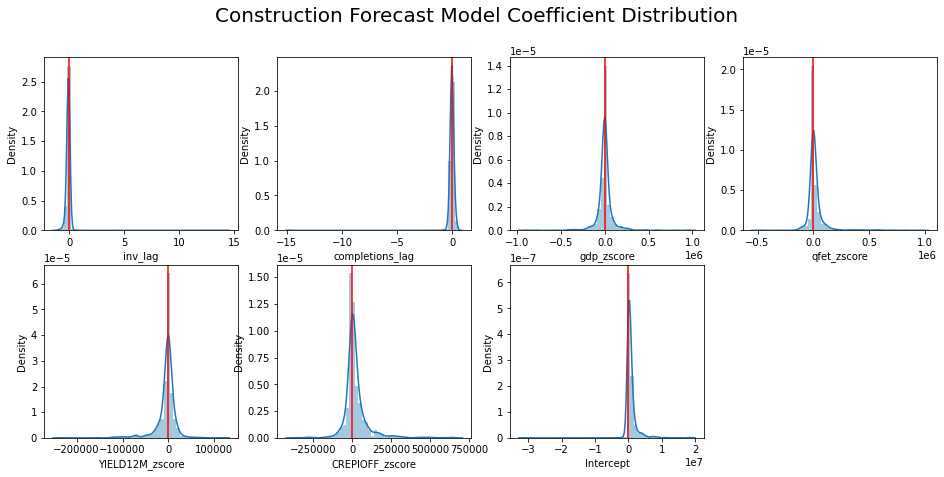

In [360]:
df = Coef_table_con.T
new_header = df.iloc[0]

df = df[1:]
df.columns = new_header

#df = df.rename(columns = { 'inv_chg' : 'inventory growth', 'inv_lag' : 'lagged inventory', 
                                #'gdp_zscore' : 'Metro GDP', 'qfet_zscore' : 'Metro Employment', 
                                #'qfhholdq_zscore' : 'Metro Households', 
                          #'qfhx1med_zscore' : 'Metro Median Single-Family Home Price change'
                         #})
#df = df.drop(columns=['Intercept'])    

fig = plt.figure(figsize=(16, 7))
y_title_margin = 0

plt.suptitle("Construction Forecast Model Coefficient Distribution", fontsize=20)

for i, col in enumerate(df.columns):
    subplot(2,4,i+1)
    sns.distplot(df[col])
    plt.axvline(x=0, color='red')

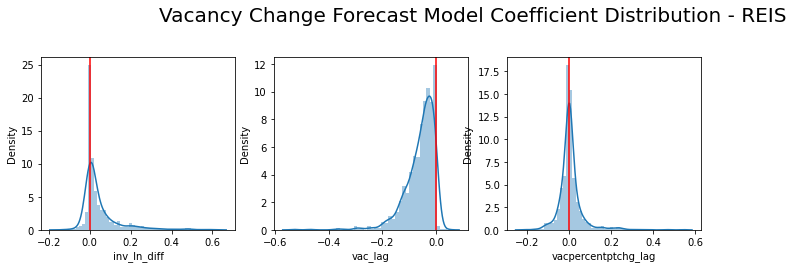

In [357]:
df = Coef_table_vac.T
new_header = df.iloc[0]

df = df[1:]
df.columns = new_header

df_1 = df.iloc[:, 0:3]
df_2 = df.iloc[:, 3:9]

#df = df.drop(columns=['Intercept'])    

fig = plt.figure(figsize=(16, 7))
y_title_margin = 0

plt.suptitle("Vacancy Change Forecast Model Coefficient Distribution - REIS", fontsize=20)

for i, col in enumerate(df_1.columns):
    subplot(2,4,i+1)
    sns.distplot(df[col])
    plt.axvline(x=0, color='red')

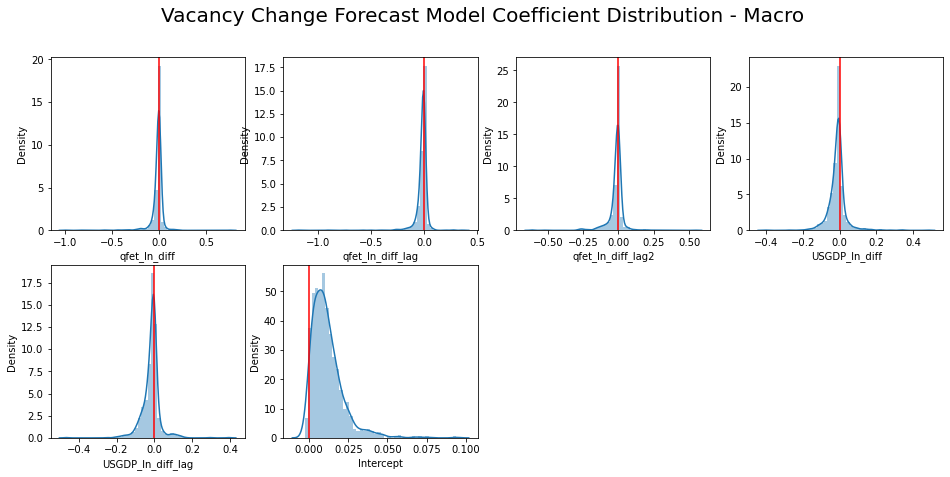

In [358]:
fig = plt.figure(figsize=(16, 7))
y_title_margin = 0

plt.suptitle("Vacancy Change Forecast Model Coefficient Distribution - Macro", fontsize=20)
for i, col in enumerate(df_2.columns):
    subplot(2,4,i+1)
    sns.distplot(df[col])
    plt.axvline(x=0, color='red')

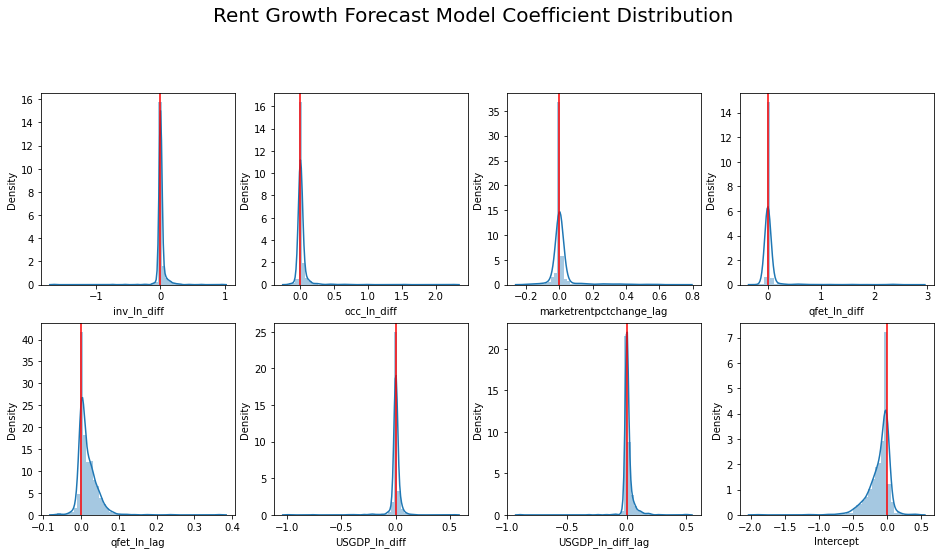

In [359]:
df = Coef_table_rent.T
new_header = df.iloc[0]

df = df[1:]
df.columns = new_header
df.columns

fig = plt.figure(figsize=(16, 12))
y_title_margin = 0

plt.suptitle("Rent Growth Forecast Model Coefficient Distribution", fontsize=20)

for i, col in enumerate(df.columns):
    subplot(3,4,i+1)
    sns.distplot(df[col])
    plt.axvline(x=0, color='red')

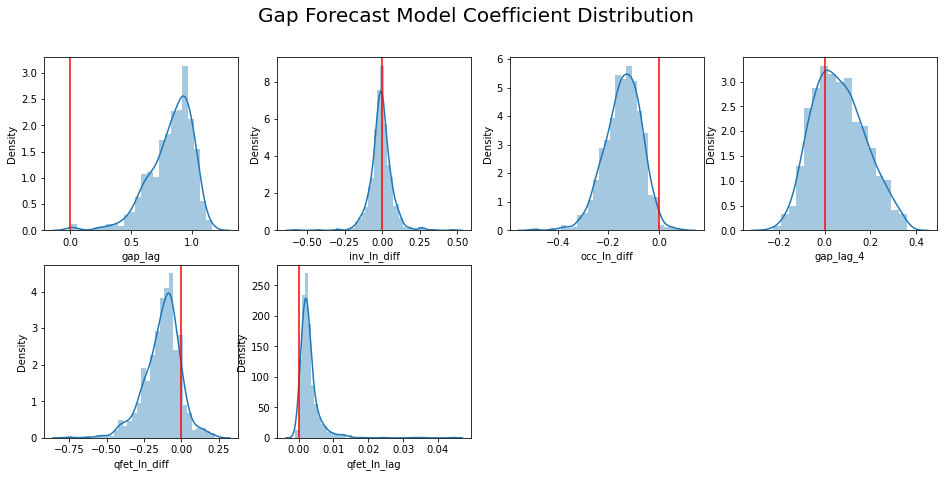

In [355]:
df = Coef_table_gap.T
new_header = df.iloc[0]

df = df[1:]
df.columns = new_header

fig = plt.figure(figsize=(16, 7))
y_title_margin = 0

plt.suptitle("Gap Forecast Model Coefficient Distribution", fontsize=20)

for i, col in enumerate(df.columns):
    subplot(2,4,i+1)
    sns.distplot(df[col])
    plt.axvline(x=0, color='red')